In [67]:
import numpy as np
import numpy.random
import pandas as pd

import matplotlib.pyplot as plt

NUM_STEPS = 12000
time = np.linspace(0, NUM_STEPS, num=NUM_STEPS, dtype=int)

# parameter used to compute anneling schedule
# T_LAMBD = 0.01 # fast
# T_LAMBD = 0.001 # slow
# T_LAMBD = 0.003 # medium

cities_df = pd.read_csv('./city.csv')
cities_df.head()

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969
1,г Майкоп,385000.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Майкоп,...,4,2,79401000000,79701000001,105,UTC+3,44.609827,40.100661,144055,1857
2,г Горно-Алтайск,649000.0,Россия,Сибирский,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,...,4,2,84401000000,84701000001,400,UTC+7,51.958103,85.960324,62861,1830
3,"Алтайский край, г Алейск",658125.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Алейск,...,4,0,1403000000,1703000001,2201,UTC+7,52.492251,82.779361,28528,1913
4,г Барнаул,656000.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Барнаул,...,4,2,1401000000,1701000001,2200,UTC+7,53.347997,83.779806,635585,1730


In [68]:


# initial state, just one city after another, indexes
x_indexes = np.linspace(0, len(cities_df.index)-1, num=len(cities_df.index), dtype=int)
x_initial = x_indexes.copy()
np.random.shuffle(x_initial)

EARTH_R = 6373.0

# memoization
seg_distance_table = {}
def seg_distance(index1, index2):
  key = "_".join(map(str, sorted([index1, index2])))
  if key in seg_distance_table:
    return seg_distance_table[key]
  # distance between two cities with given indices
  # print(f"index1: {index1} index2: {index2}")
  lat1, lon1 = np.radians(cities_df.iloc[index1]['geo_lat']), np.radians(cities_df.iloc[index1]['geo_lon'])
  lat2, lon2 = np.radians(cities_df.iloc[index2]['geo_lat']), np.radians(cities_df.iloc[index2]['geo_lon'])
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
  seg_distance_table[key] = EARTH_R * c
  return seg_distance_table[key]

def path_distance(x):
  total = seg_distance(x[0], x[len(x)-1])
  for i in range(len(x)-1):
    #print(f"total {total}")
    total += seg_distance(x[i], x[i+1])
  return total

T_0 = path_distance(x_initial)

# exponential decay
def temp(t, TLAMBD):
  return T_0*np.exp(-TLAMBD*t)

def p_star(x, T):
  return np.exp(-path_distance(x)/T)

def generate_next(x):
  # just swap two random cities in the path
  index1, index2 = np.random.choice(x_indexes, 2)
  x_next = x.copy()
  tmp = x_next[index1]
  x_next[index1] = x_next[index2]
  x_next[index2] = tmp
  return x_next

def simulated_annealing(x_initial, TLAMBD):
  shortest_path = np.zeros(time.shape)
  shortest_path[0] = path_distance(x_initial)
  x = x_initial
  T = temp(0, TLAMBD)
  for i in range(0, len(time)):
    T = temp(i, TLAMBD)

    # if temperature has cooled down
    # then we should stop computing anything
    # we found our solution
    if T < 0.000001:
      shortest_path[i] = path_distance(x)
      continue

    x_next = generate_next(x)
    if path_distance(x_next) < path_distance(x):
      x = x_next
    else:
      alpha = p_star(x_next, T)/p_star(x, T)
      u = np.random.uniform()
      if u <= alpha:
        x = x_next
    shortest_path[i] = path_distance(x)
  return shortest_path, x


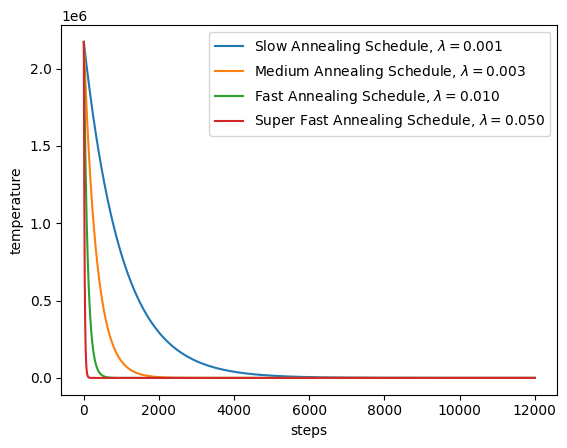

In [69]:
plt.plot(time, temp(time, TLAMBD=0.001), label=r"Slow Annealing Schedule, $\lambda = 0.001$")
plt.plot(time, temp(time, TLAMBD=0.003), label=r"Medium Annealing Schedule, $\lambda = 0.003$")
plt.plot(time, temp(time, TLAMBD=0.010), label=r"Fast Annealing Schedule, $\lambda = 0.010$")
plt.plot(time, temp(time, TLAMBD=0.050), label=r"Super Fast Annealing Schedule, $\lambda = 0.050$")
plt.xlabel("steps")
plt.ylabel("temperature")
plt.legend()
plt.show()

<ipython-input-68-0cbd9c2c914b>:69: RuntimeWarning: invalid value encountered in double_scalars
  alpha = p_star(x_next, T)/p_star(x, T)


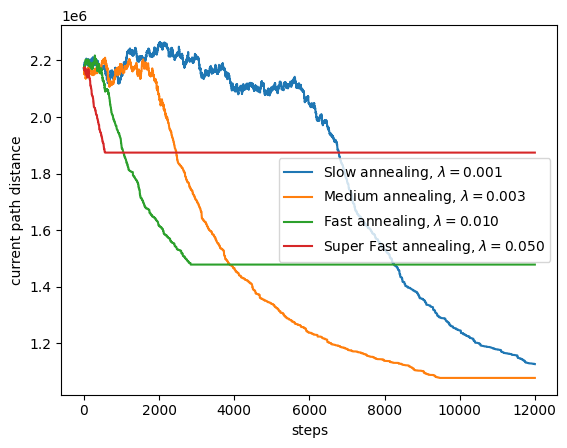

In [70]:
# T_LAMBD = 0.01 # fast
# T_LAMBD = 0.003 # medium
# T_LAMBD = 0.001 # slow

slow_shortest_path, slow_final_x = simulated_annealing(x_initial, TLAMBD=0.001)
medium_shortest_path, medium_final_x = simulated_annealing(x_initial, TLAMBD=0.003)
fast_shortest_path, fast_final_x = simulated_annealing(x_initial, TLAMBD=0.010)
sfast_shortest_path, sfast_final_x = simulated_annealing(x_initial, TLAMBD=0.050)

plt.plot(time, slow_shortest_path, label=r"Slow annealing, $\lambda = 0.001$")
plt.plot(time, medium_shortest_path, label=r"Medium annealing, $\lambda = 0.003$")
plt.plot(time, fast_shortest_path, label=r"Fast annealing, $\lambda = 0.010$")
plt.plot(time, sfast_shortest_path, label=r"Super Fast annealing, $\lambda = 0.050$")
plt.xlabel("steps")
plt.ylabel("current path distance")
plt.legend()
plt.show()

In [73]:
[slow_shortest_path[-1], medium_shortest_path[-1], fast_shortest_path[-1], sfast_shortest_path[-1]]

[1127083.4001128513,
 1078357.2153895637,
 1478766.9219608556,
 1874333.8154222176]

In [72]:
temp(10000, 0.05) < 0.0000001

True